In [434]:
#==============Imports and Load Audio===============#
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
from scipy import signal

fs_mod, modulator = wavfile.read('modulator.wav')
fs_car, carrier = wavfile.read('organ_carrier.wav')

# make sure files are the same sampling rate
fs = min(fs_mod, fs_car)
modulator = signal.resample(modulator, (len(modulator)//fs_mod)*fs)
carrier = signal.resample(carrier, (len(carrier)//fs_car)*fs)

# trim carrier and modulator to same length
carrier = carrier[:min(len(modulator), len(carrier))]
modulator = modulator[:min(len(modulator), len(carrier))]

# if there are two channels, just use one
if len(carrier.shape) > 1:
    carrier = carrier[:,0]
if len(modulator.shape) > 1:
    modulator = modulator[:,0]
    
# Normalize signals
carrier = carrier/(np.max(carrier))
modulator = modulator/(np.max(modulator))

print(len(carrier))
print(len(modulator))

Audio(modulator, rate=fs)

44100
44100


In [450]:
#==============Window Functions===============#
def get_hamming(L):
    """ returns coefficients for hamming window of length L"""
    # TODO: doesn't work, reconstruction sounds clippy
    return 0.54 - (0.46*np.cos(2*np.pi*np.arange(L)/L))

def get_bartlett(L):
    """ returns coefficients for bartlett/triangular window 
        of length L
        window should have 50% 
        (hop size R should be window size M / 2)"""
    half = 2* np.arange(L//2) / L
    return np.concatenate((half, np.flip(half)))
def get_hanning(L):
    """ returns coefficients for hanning window of length L"""
    return 0.5* (1-np.cos(2*np.pi*np.arange(L)/L+1))


In [461]:
#==============STFT Functions===============#
def get_windowed_signal(signal, L, R, w=None):
    """
    Partitions signal into windows of length M, separated by R samples
    returns: M x N matrix, where M is the window size, and N is number of windows
    """ 
    xms = np.array([np.zeros(L)]).T  # ini
    ws = w(L) if w is not None else None
    signal = np.concatenate([np.zeros(L//2), signal, np.zeros(L//2)])  # for COLA reconstruction
        # TODO: do we need to strip these zeros in istft?
    ms = range(0, len(signal), R)
    for m in ms:
        xm = signal[m:m+L].copy()
        if len(xm) < L:
            xm = np.concatenate([xm, np.zeros(L-len(xm))])
        if ws is not None:  # apply window fn
            xm *= ws
        xm = np.array([xm]).T
        xms = np.hstack([xms,xm])
    return xms[:, 1:]  # discard first column of all zeros


def get_stft(windowed_signal, nfft=None):
    """
    :param windowed_signal: windowed signal matrix
    :param nfft: the size of the fft.
    
    :return 2-D matrix where each column is a single fft frame 
    """
    if nfft is None:
        nfft = windowed_signal.shape[0]
    ms = windowed_signal.shape[1]
    ffts = np.array([np.zeros(nfft)]).T
    for m in range(ms):
        xm = windowed_signal[:, m]
        freq_window = np.array([np.fft.fft(xm, nfft)]).T
        ffts = np.hstack([ffts, freq_window])
    return ffts[:, 1:]


def get_istft(stft, R):
    """ 
    Performs Overlap-Add reconstruction of original signal
    """
    nfft = stft.shape[0]  # size of the fft
    num_frames = stft.shape[1]  # number of fft windows
    signal = np.zeros((R * (num_frames - 1)) + nfft)
    for m in range(num_frames):
        idx = m*R
        windowed_signal = (np.fft.ifft(stft[:, m])).real
        signal[(idx):idx+nfft] += windowed_signal
    return signal #* (1/nfft)


def plot_spectrogram(stft, fs, R, title="", colorbar=False):    
    """
    plot spectrogram of stft
    """
    plt.figure(figsize=[10,5])
    L = stft.shape[0]
    num_frames = stft.shape[1]
    # we only look at FFT freq up to nyquist limit fs/2, and normalize out imag components
    stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)
    plt_spec = plt.imshow(
        stft_db,
        origin='lower'
    )
    
    ## create ylim
    num_yticks = 10
    ks = np.linspace(0, L/2, num_yticks)
    ks_hz = ks * fs // (L)
    plt.yticks(ks,ks_hz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    num_xticks = 10
    ts_spec = np.linspace(0, num_frames, num_xticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0, (R*num_frames)/fs, num_xticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title(f"{title} L={L} hopsize={R}, fs={fs} Spectrogram.shape={stft.shape}")
    if colorbar:
        plt.colorbar(None, use_gridspec=True)
    plt.show()
    return(plt_spec)


In [462]:
#==============LPC Functions===============#

def gen_autocorrelates(x, M):
    """
    returns [r_0, r_1, ..., r_M]
    """
    rx = np.zeros(M+1)
    for i in range(M+1):
        rx[i] = np.dot(x[:len(x)-i],x[i:])
    return rx


def gen_toeplitz(rx, M):
    covmatrix = np.zeros((M,M))
    for i in range(0,M):
        for j in range(0,M):
            covmatrix[i, j] = rx[np.abs(i-j)]
    return covmatrix


def gen_lp_coeffs(x, M):
    """
    returns a_0, a_1, ... a_M for a signal x
    """
    rx = gen_autocorrelates(x, M)
    toeplitz = gen_toeplitz(rx, M)          
    coeffs, _, _, _ = np.linalg.lstsq(
        toeplitz,
        -1*rx[1:], 
        rcond=None
    )
    return np.concatenate(([1], coeffs))


def gen_lpc_spec_envs(windowed_modulator, M, nfft):
    """
    :param windowed_modulator: matrix where each column is a windowed signal
    :param M: order of linear predictor
    :param nfft: fft size

    Returns a matrix of spectral envelopes, where column m is spectral envelope for m'th signal frame
    """
    num_frames = windowed_modulator.shape[1]
    spec_envs = np.array([np.zeros(nfft)]).T
    for m in range(num_frames):
        xm = windowed_modulator[:, m]  # get mth column
        coeffs = gen_lp_coeffs(xm, M)
        spec_env = np.array([1/(np.abs(np.fft.fft(coeffs, nfft)))]).T
        spec_envs = np.hstack([
            spec_envs, 
            spec_env
        ])
    return spec_envs[:, 1:]
    

In [463]:
#==============Cross-Synthesis===============#

def cross_synthesize(fs, carrier, modulator, L, R, M, flatten=False, w=None, plot=False):
    """
    :param fs: sample rate
    :param carrier: carrier signal in time
    :param modulator: modulator signal in time
    :param L: window size
    :param R: hop size
    :param M: number of coefficients
    :param flatten: if true, divide carrier spectrum by its own envelope
    :param w: window coefficients
    :param plot: if true, will generate spectrograms
    
    returns stft of cross-synthesized signal, and cross-synthesized audio signal
    """
    # to prevent time-domain aliasing, make nfft size double the window size
    nfft = L*2  # convolution length of two length-L signals, the whitening filter and windowed signal
    
    windowed_carrier = get_windowed_signal(carrier, L, R, w=w)
    windowed_modulator = get_windowed_signal(modulator, L, R, w=w)
    
    carrier_stft = get_stft(windowed_carrier, nfft)
    modulator_stft = get_stft(windowed_modulator, nfft)
    if plot:
        plot_spectrogram(carrier_stft, fs, R, title="original carrier")
        plot_spectrogram(modulator_stft, fs, R, title="modulator")
    
    # Optional: divide spectrum of carrier frame by its own envelope 
    if flatten:
        carrier_spec_envs = gen_lpc_spec_envs(windowed_carrier, M, nfft)
        carrier_stft = carrier_stft / carrier_spec_envs
        if plot: 
            plot_spectrogram(carrier_stft, fs, R, title="flattened carrier")
    
    # Multiply carrier spectral frame by modulator spectral envelops
    modulator_spec_envs = gen_lpc_spec_envs(windowed_modulator, M, nfft)
    cross_synth_stft = carrier_stft * modulator_spec_envs
    if plot: 
        plot_spectrogram(cross_synth_stft, fs, R, title="cross-synthesized carrier")
    
    return cross_synth_stft, get_istft(cross_synth_stft, R)

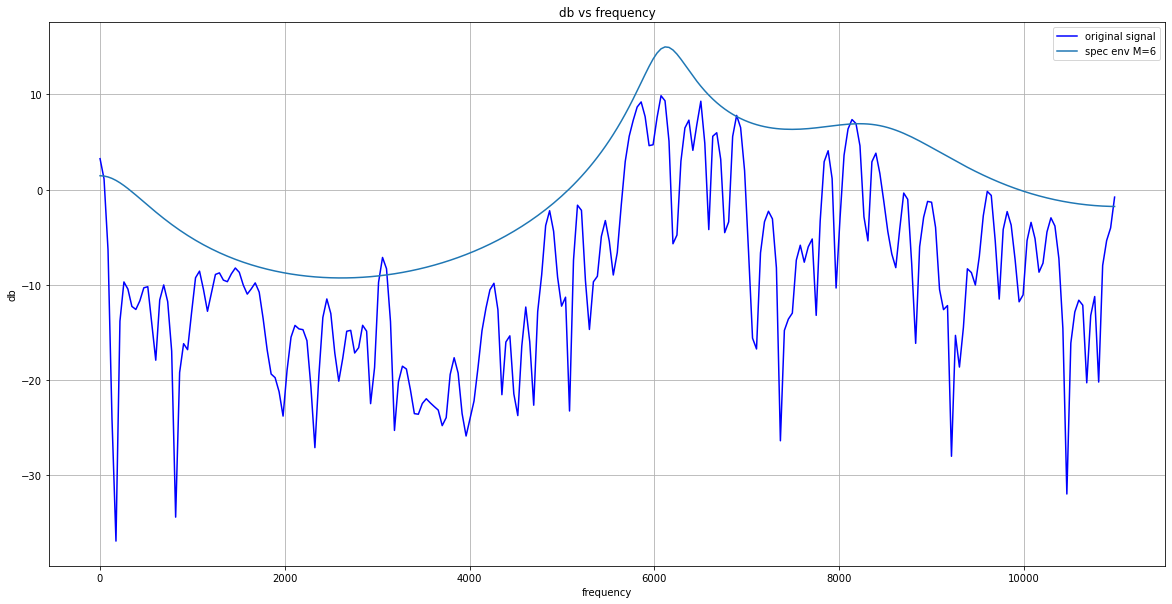

In [499]:
#==============Visualize LPC envelope on first frame of modulator===============#

N = 256
nfft = N*2
frame = 19
freq_spec = np.arange(nfft/2)*fs/(nfft)

windowed_modulator = get_windowed_signal(modulator, N, N, w=get_bartlett)
modulator_fft = np.fft.fft(windowed_modulator[:,frame], nfft)
modulator_fft_db = 20. * np.log10(np.abs( modulator_fft ))

plt.figure(figsize=(20,10))
plt.plot(freq_spec, modulator_fft_db[:nfft//2], color = "blue", label = "original signal")
for M in range(6,7):
    modulator_spec_envs = gen_lpc_spec_envs(windowed_modulator, M, nfft)
    plt.plot(freq_spec, (20. * np.log10(np.abs(modulator_spec_envs[:, frame])))[:nfft//2], label = f"spec env M={M}")
plt.grid()
plt.legend(loc = 'upper right')
plt.title("db vs frequency")
plt.xlabel("frequency")
plt.ylabel("db")
plt.show()

<ipython-input-461-c86e4b335002>:63: RuntimeWarning: divide by zero encountered in log10
  stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)


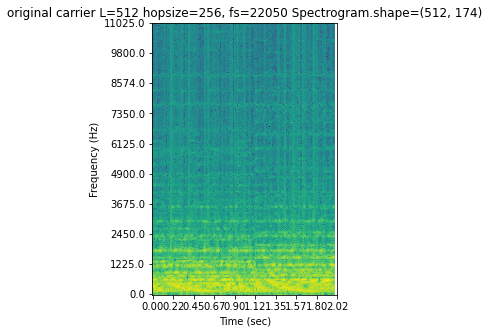

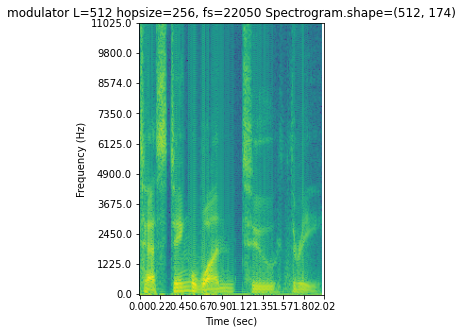

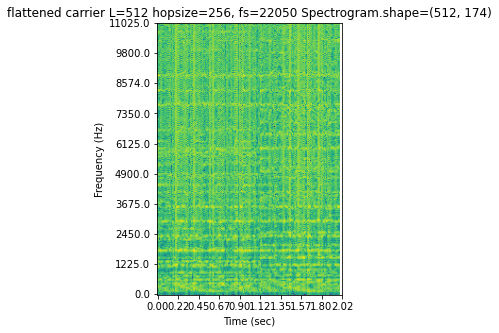

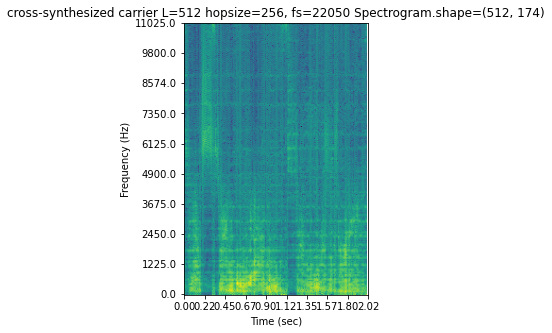

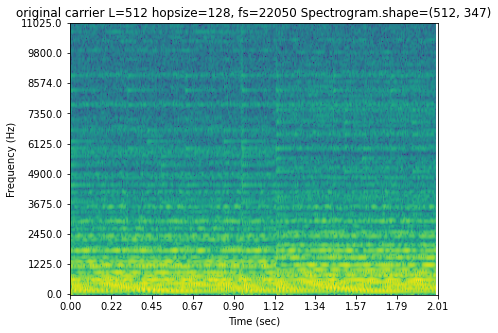

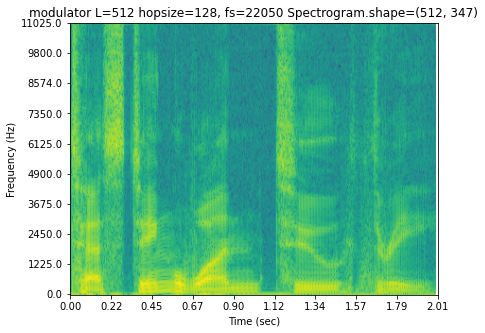

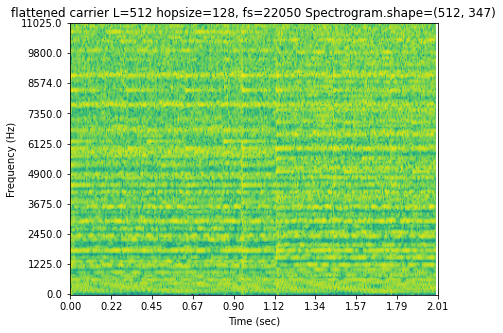

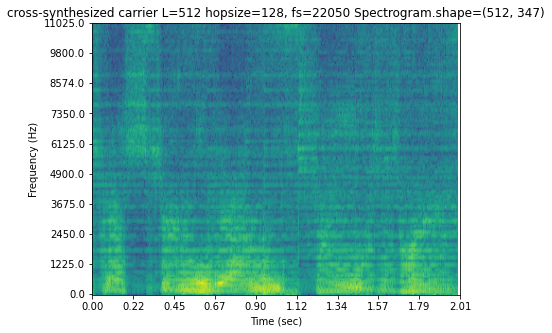

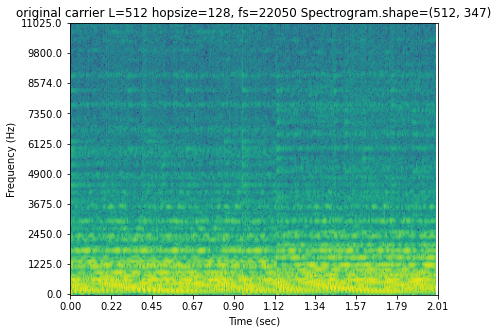

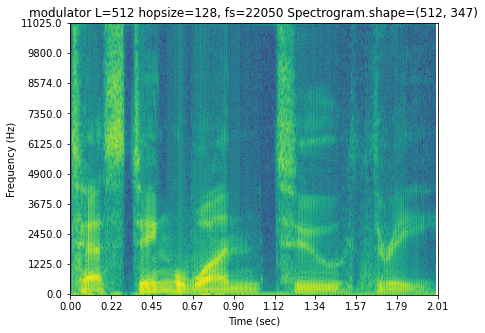

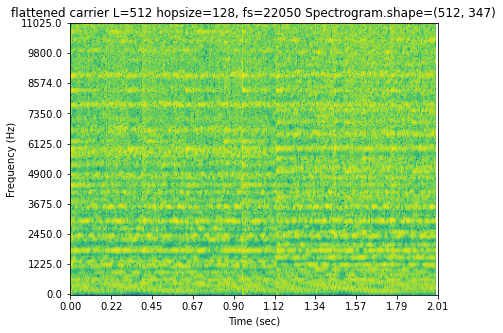

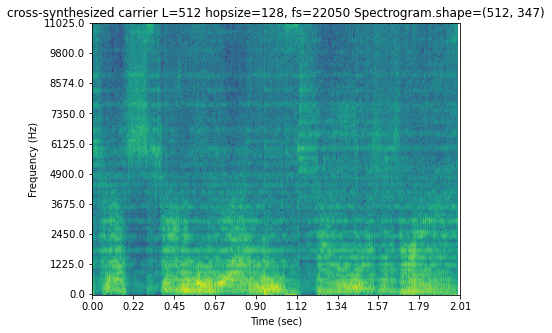

In [468]:
#==============Perform cross-synthesis===============#


M = 6  # num linear coefficients
L = 256  # window size
R = L  # hop size

# Cross-synthesize using rectangular window with 0 overlap
cross_synth_stft, cross_synth_audio = \
    cross_synthesize(
        fs,
        carrier, 
        modulator, 
        L, 
        R, 
        M, 
        flatten=True,
        w=None,
        plot=True
    )

M = 6  # num linear coefficients
L = 256  # window size
R = L // 2  # hop size

# Cross-synthesize using bartlett window with 50% overlap
cross_synth_stft_bart, cross_synth_audio_bart = \
    cross_synthesize(
        fs,
        carrier, 
        modulator, 
        L, 
        R, 
        M, 
        flatten=True,
        w=get_bartlett,
        plot=True
    )

M = 6  # num linear coefficients
L = 256  # window size
R = L // 2  # hop size

# Cross-synthesize using hanning window with 50% overlap
cross_synth_stft_hann, cross_synth_audio_hann = \
    cross_synthesize(
        fs,
        carrier, 
        modulator, 
        L, 
        R, 
        M, 
        flatten=True,
        w=get_hanning,
        plot=True
    )

In [469]:
#==============Play cross-synthesized audio===============#
Audio(cross_synth_audio, rate=fs)


In [470]:
Audio(cross_synth_audio_hann, rate=fs)

In [471]:
Audio(cross_synth_audio_bart, rate=fs)